In [15]:
## Create Colab Notebook folder
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Colab Notebooks" "/content/Colab Notebooks"

# Put Colab in the context of the project
import os
# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/Colab Notebooks/AerialImageDataset')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [16]:
%cd /content/Colab Notebooks
## for first time
# !git clone https://github.com/JennyF-slb/solar_ai.git 
%cd /content/Colab Notebooks/solar_ai
## for subsequent
!git pull
# !pip install -r minimal_requirements.txt

/gdrive/My Drive/Colab Notebooks
fatal: destination path 'solar_ai' already exists and is not an empty directory.
/gdrive/My Drive/Colab Notebooks/solar_ai
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Import Libraries

In [39]:
import os
import glob

# from osgeo import gdal
import rasterio

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

from PIL import Image

In [32]:
import tensorflow as tf

# Check if TensorFlow is using GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        print(f"GPU Device Name: {device.name}")
else:
    print("No GPU devices found. Make sure TensorFlow GPU is properly installed.")

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)

No GPU devices found. Make sure TensorFlow GPU is properly installed.
TensorFlow Version: 2.12.0


# 2. Seeding

In [33]:
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

# 3. Hyperparameters

In [34]:
batch_size = 8 
lr = 1e-4
epochs = 100 
height =  256
width = 256

# 4. Set Data Path

In [84]:
dataset_path = r'C:\Users\MLee27\Documents\Coding\LeWagon_Assessment2\solar_ai\data\aerialimagelabeling\AerialImageDataset'
model_file = r'C:\Users\MLee27\Documents\Coding\LeWagon_Assessment2\solar_ai\models\unet_non_aug.h5'
log_file = r'C:\Users\MLee27\Documents\Coding\LeWagon_Assessment2\solar_ai\logs\logs_non_aug.csv'

# 5. Data Pipeline

Read image and mask 

In [85]:
def list_folder_tree(folder_path):
    for root, dirs, _ in os.walk(folder_path):
        if os.path.basename(root) != '.ipynb_checkpoints':
            level = root.replace(folder_path, '').count(os.sep)
            indent = ' ' * 4 * (level)
            print('{}{}/'.format(indent, os.path.basename(root)))

# Provide the path to your project data folder
folder_path = dataset_path

# Call the function to list the folder tree
list_folder_tree(folder_path)

AerialImageDataset/
    test/
        images/
    train/
        gt/
        images/


In [98]:
## read train and test images & masks
train_images = os.path.join('..',dataset_path, 'train', 'images')
train_masks = os.path.join('..',dataset_path, 'train','gt')
test_images = os.path.join('..', dataset_path, 'test', 'images')

In [101]:
def load_geotiff_data(image_folder):
    file_paths = [os.path.join(train_images, filename) for filename in sorted(os.listdir(train_images)) if filename.endswith('.tif')]
    
    image_tensors = []
    for image_file in file_paths:
        with rasterio.open(image_file) as image:
            if image_file is None:
                continue
            data = image.read() # Convert to array
            image.close()  # Close the dataset
            c_image = np.transpose(data,(1,2,0)) # Transpose the position of channels in the image
            image_tensors.append(c_image)
            
    return image_tensors

In [102]:
# Open GeoTIFF file in a loop
train_data = load_geotiff_data(train_images)

['C:\\Users\\MLee27\\Documents\\Coding\\LeWagon_Assessment2\\solar_ai\\data\\aerialimagelabeling\\AerialImageDataset\\train\\images\\austin1.tif', 'C:\\Users\\MLee27\\Documents\\Coding\\LeWagon_Assessment2\\solar_ai\\data\\aerialimagelabeling\\AerialImageDataset\\train\\images\\austin10.tif', 'C:\\Users\\MLee27\\Documents\\Coding\\LeWagon_Assessment2\\solar_ai\\data\\aerialimagelabeling\\AerialImageDataset\\train\\images\\austin11.tif', 'C:\\Users\\MLee27\\Documents\\Coding\\LeWagon_Assessment2\\solar_ai\\data\\aerialimagelabeling\\AerialImageDataset\\train\\images\\austin12.tif', 'C:\\Users\\MLee27\\Documents\\Coding\\LeWagon_Assessment2\\solar_ai\\data\\aerialimagelabeling\\AerialImageDataset\\train\\images\\austin13.tif', 'C:\\Users\\MLee27\\Documents\\Coding\\LeWagon_Assessment2\\solar_ai\\data\\aerialimagelabeling\\AerialImageDataset\\train\\images\\austin14.tif', 'C:\\Users\\MLee27\\Documents\\Coding\\LeWagon_Assessment2\\solar_ai\\data\\aerialimagelabeling\\AerialImageDataset\\t

In [104]:
print(len(images_tensors))

180


In [105]:
for i in images_tensors:
    print(i.shape)
    break

(5000, 5000, 3)


[[[ 46  53  70 ...  84  87  60]
  [ 62  67  76 ...  82  72  63]
  [ 78  79  76 ...  72  63  71]
  ...
  [ 50  55  49 ... 164 158 131]
  [ 38  47  41 ... 191 164 138]
  [ 36  47  40 ... 214 175 161]]

 [[ 66  72  89 ... 108 111  84]
  [ 82  87  95 ... 106  97  88]
  [ 98  99  96 ...  98  89  97]
  ...
  [ 69  74  68 ... 169 166 141]
  [ 56  65  60 ... 195 169 146]
  [ 54  65  59 ... 218 180 169]]

 [[ 67  76  93 ... 108 111  84]
  [ 83  88  99 ... 106  94  85]
  [ 97 100  97 ...  95  86  94]
  ...
  [ 86  91  83 ... 172 168 142]
  [ 76  85  77 ... 198 172 148]
  [ 76  85  76 ... 221 183 171]]]
(5000, 5000, 3)
<class 'numpy.ndarray'>
21
255


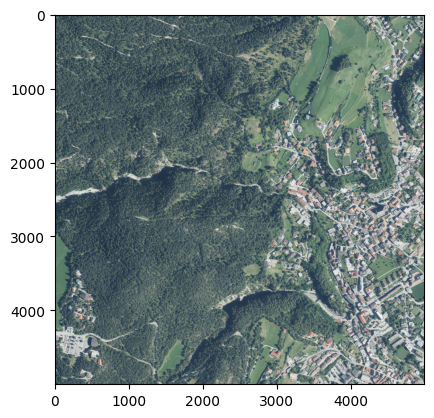

In [44]:
# Open the GeoTIFF file.
with rasterio.open(r'C:\Users\MLee27\Documents\Coding\LeWagon_Assessment2\solar_ai\data\aerialimagelabeling\AerialImageDataset\train\images\tyrol-w1.tif') as image:
# with rasterio.open(r'C:\Users\MLee27\Documents\Coding\LeWagon_Assessment2\solar_ai\data\aerialimagelabeling\AerialImageDataset\train\gt\tyrol-w1.tif') as image:
    # Read the data from the GeoTIFF file.
    data = image.read()

    # Close the GeoTIFF file.
    image.close()

# Do something with the data.
print(data)
c_image = np.transpose(data,(1,2,0))
print(c_image.shape)
plt.imshow(c_image)

print(type(c_image))
print(np.min(c_image))
print(np.max(c_image))

In [ ]:
# Preprocessing Utilities

def random_flip(input_image, input_mask):
  '''does a random flip of the image and mask'''
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask


def normalize(input_image, input_mask):
  '''
  normalizes the input image pixel values to be from [0,1].
  subtracts 1 from the mask labels to have a range from [0,2]
  '''
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  '''resizes, normalizes, and flips the training data'''
  input_image = tf.image.resize(datapoint['image'], (height, width), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (height, width), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask


def load_image_test(datapoint):
  '''resizes and normalizes the test data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Define train and test dataset 

In [ ]:
# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)


Load as numpy tensor 

make it to train, test dataloader 

# 7. Data Visualization / EDA

# 8. Data Augmentation - To handle imbalance class

-- VFlip, HFlip, Rotation, RandomCrop, ....(To research) 

-- Check if need to apply GAN / Diffusion model to generate synthetic data

# 10. Define Model (-- Need handle imbalance class)

## 10.1 Base Model

## 10.2 Unet

In [ ]:
## Convolution Layer

def conv2d_block (input_tensor, n_filters, kernel_size =3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters,
                                   kernel_size = (kernel_size, kernel_size))(x)
        ## can add batch normalization to speed up training and make learning easier
        # x = tf. BatchNormalization
        x = tf.keras.layers.Activation('relu')(x)

    return x 

In [ ]:
## Encoder block

def encoder_block(inputs, n_filters, pool_size, dropout):
    f = conv2d_block(inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)
    
    return f,p

In [ ]:
## Calling encoder

def encoder(inputs):
    f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
    f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
    f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
    f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)
    
    return p4, (f1, f2, f3, f4)

In [ ]:
def bottleneck (inputs):
    bottle_neck = conv2d_block(inputs, n_filters=1024)
    
    return bottle_neck

In [ ]:
## decoder block

def decoder_block (inputs, conv_output, n_filters, kernel_size, strides, dropout):
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides=strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output]) ## skip connection
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)
    
    return c

In [ ]:
## calling decoder

def decoder(inputs, convs):
    f1, f2, f3, f4 = convs
    
    c6 = decoder_block(inputs. f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    
    outputs = tf.keras.layers.Conv2D(3,(1,1), activation='softmax')(c9)  ## 3 because we have 3 classes
    
    return outputs
    

In [ ]:
## unet model

def unet():
    inputs = tf.keras.layers.Input(shape=(128,128,3)) ## height x width x channel size
    encoder_output , convs =  encoder(input)
    
    bottle_neck = bottleneck(encoder_output)

    outputs = decoder(bottle_neck, convs)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    
    return model

In [ ]:
 # Compile the model
def compile(self, optimizer='adam', loss='binary_crossentropy'):
    # Use the compile method of the Model class to compile the model.
    # The optimizer controls the learning rate and the loss function calculates the difference between the
    # model's predictions and the true values
    self.model.compile(optimizer=optimizer, loss=loss)

# Train the model
def train(self, x, y, epochs=10, batch_size=128, validation_split=0.1):
    # Use the fit method of the Model class to train the model.
    # x is the input data, y is the target data, epochs is the number of times to iterate over the entire dataset,
    # batch_size is the number of samples per gradient update, and validation_split fraction of the data to use as validation data.
    self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

# Use the model to make predictions
def predict(self, x):
    # Use the predict method of the Model class to generate output predictions for the input samples.
    return self.model.predict(x)

## 10.3 Segformer

# 11. Model Training (Cross Validation 5 fold)

# 12. Model Evalution (Loss Function)


# 13. Callback - to save the model checkpoint

# 14. Model Interpretation (Class Activation Map)

### 14.1 Gradient CAM, Salient Map



# 15. Model Prediction/ Inference